In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys

sys.path.append("../incl/")

import ELPH_utils
import ELPH_dyn
import codimar

In [2]:
runs = ELPH_utils.load_runs(filename='/home/agluedge/Preprints/ELPH/runs/runs_n_kmax=200.npz')

# runs = runs[::1]
# for k in range(len(runs)):
#     runs[k] = runs[k][:,::2]

n_runs = len(runs)
n_kmax = runs[0].shape[0]

print(n_runs, 'loaded with n_kmax =', n_kmax)

test_run = ELPH_utils.load_runs(filename='/home/agluedge/Preprints/ELPH/example_run.npz')[0]
print('example run loaded with shape: ', test_run.shape)


1000 loaded with n_kmax = 200
example run loaded with shape:  (200, 400)


In [3]:
optimizer = codimar.optimizer.ridge(alpha=10.**-3.5)
scaler = codimar.scaler.normalize_scaler(0.1)
dim_reducer = codimar.dim_compressor.SVD()
transformer = codimar.transformer.polynomial_features(order=2)

model = codimar.codimar(runs, n_VAR_steps=2, intercept=True, full_hist=False, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=transformer)
model.train(rdim=20, prdim = 20)
model.print_status()

full_hist:  False
intercept:  True
standardize:  True
rdim:  20
prdim:  20
n_VAR_steps:  2
train shape:  (861, 399000)
target shape:  (20, 399000)
weights shape:  (861, 20)


In [4]:
pred = model.predict_single_run(test_run)

print('std error: ', model.get_error(test_run, pred, norm='std') )
print('max error: ', model.get_error(test_run, pred, norm='max') )

std error:  0.003235759206859351
max error:  0.09517082553297851


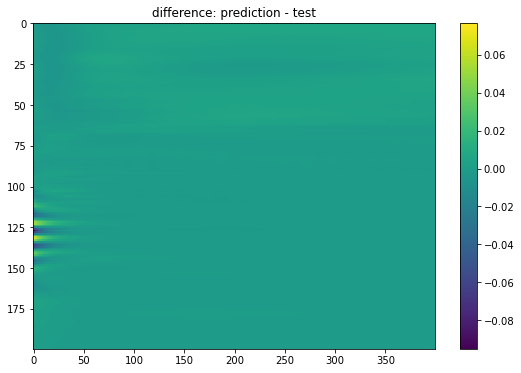

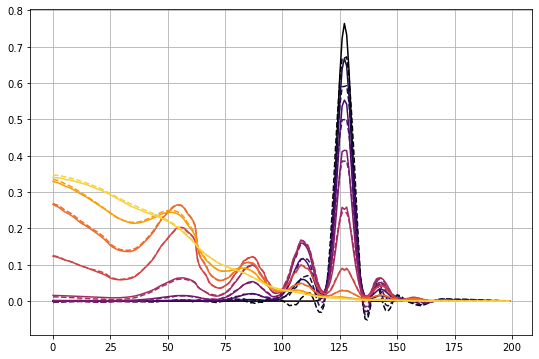

std error:  0.0022254074020196368
max error:  0.007162926328409036


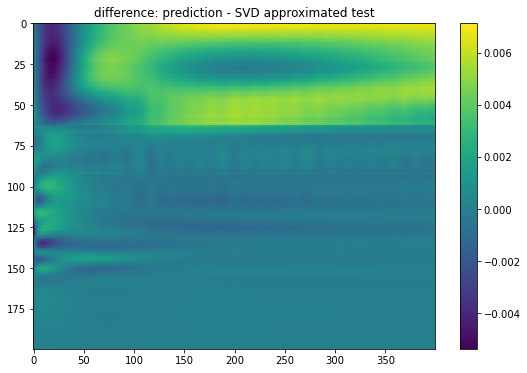

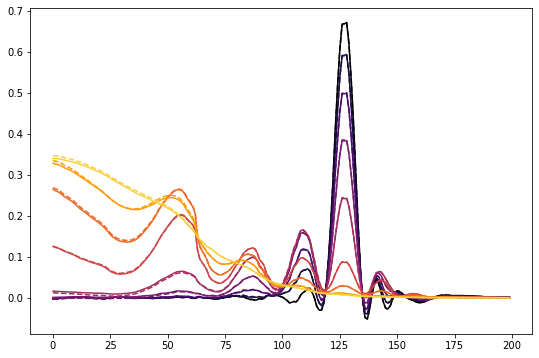

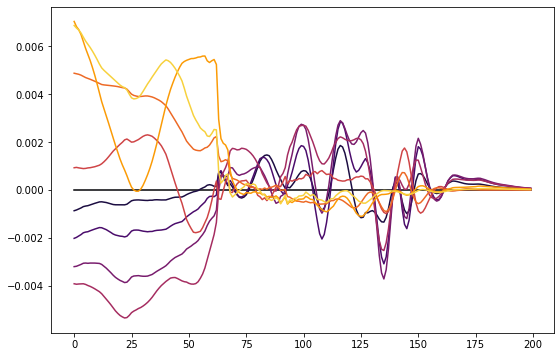

In [5]:

plt.imshow(pred-test_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - test')
plt.show()


colors = plt.get_cmap('inferno')
tn_arr = [0,2,5,10,20,50,100,200,399]
plt.grid()

for k,tn in enumerate(tn_arr):
    plt.plot(test_run[:,tn], '-', c=colors(k/len(tn_arr)))
    plt.plot(pred[:,tn], '--', c=colors(k/len(tn_arr)))
plt.show()


test_run_SVDapprx = dim_reducer.U[:,:20] @ dim_reducer.U[:,:20].T @ test_run

print('std error: ', model.get_error(test_run_SVDapprx, pred, norm='std') )
print('max error: ', model.get_error(test_run_SVDapprx, pred, norm='max') )


plt.imshow(pred - test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - SVD approximated test')
plt.show()


for k,tn in enumerate(tn_arr):
    plt.plot(test_run_SVDapprx[:,tn], '-', c=colors(k/len(tn_arr)))
    plt.plot(pred[:,tn], '--', c=colors(k/len(tn_arr)))
plt.show()

for k,tn in enumerate(tn_arr):
    plt.plot(pred[:,tn]-test_run_SVDapprx[:,tn], '-', c=colors(k/len(tn_arr)))
plt.show()



In [6]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=False):
        """
        Map value to the interval [0, 1]. The clip argument is unused.
        """
        result, is_scalar = self.process_value(value)
        self.autoscale_None(result)  # sets self.vmin, self.vmax if None

        if not self.vmin <= self.vcenter <= self.vmax:
            raise ValueError("vmin, vcenter, vmax must increase monotonically")
        result = np.ma.masked_array(
            np.interp(result, [self.vmin, self.vcenter, self.vmax],
                      [0, 0.5, 1.]), mask=np.ma.getmask(result))
        if is_scalar:
            result = np.atleast_1d(result)[0]
        return result

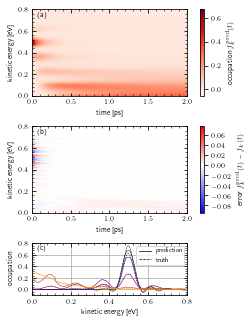

In [7]:
tmax = 2
n_tmax = 400
kmax = 4


E_el = ELPH_dyn.electron_dispersion(np.linspace(0,kmax,n_kmax,endpoint=True),0)
t = np.linspace(0,tmax,test_run.shape[1])

err = pred-test_run


####################################################
####################################################
####################################################

from matplotlib import rc
rc('text', usetex=True)

from matplotlib import gridspec
import matplotlib.ticker as ticker

fs = 7
fig = plt.figure(figsize=(3.5,4.5))
plt.rcParams.update({'font.size': fs})
gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=[1,0.025], height_ratios=[1,1,0.6])


####################################################
####################################################
####################################################


ax00 = plt.subplot(gs[0,0])

im = plt.pcolormesh(t,E_el,pred, cmap='Reds', shading='auto', rasterized=True)
# cbar = plt.colorbar()
# cbar.set_label(r'error')

# plt.xlim(0,1.2)
plt.ylim(0,0.8)


plt.xlabel(r'time [ps]')
plt.ylabel(r'kinetic energy [eV]')

ax00.xaxis.set_ticks_position('both')
ax00.yaxis.set_ticks_position('both')
ax00.tick_params(which='both', direction='in', color='k')

ax00.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax00.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
# ax00.xaxis.set_major_formatter(ticker.NullFormatter())
# ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

ax00.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax00.yaxis.set_minor_locator(ticker.MultipleLocator(0.04))
#ax00.yaxis.set_major_formatter(ticker.NullFormatter())
#ax00.yaxis.set_minor_formatter(ticker.NullFormatter())

plt.text(0.03, 0.97,r'(a)', horizontalalignment='left', verticalalignment='top', transform=ax00.transAxes)


axCB = plt.subplot(gs[0,1])

cb = plt.colorbar(im, cax = axCB)
cb.set_label(r"occupation $f_k^{\rm pred}(t)$")


####################################################
####################################################
####################################################


ax00 = plt.subplot(gs[1,0])

vmin = err.min()
vmax = err.max()
        
midnorm = MidpointNormalize(vmin=vmin, vcenter=0.0, vmax=vmax)

im = plt.pcolormesh(t,E_el,err,norm=midnorm, cmap='bwr', shading='auto', rasterized=True)
# cbar = plt.colorbar()
# cbar.set_label(r'error')

# plt.xlim(0,1.2)
plt.ylim(0,0.8)


plt.xlabel(r'time [ps]')
plt.ylabel(r'kinetic energy [eV]')

ax00.xaxis.set_ticks_position('both')
ax00.yaxis.set_ticks_position('both')
ax00.tick_params(which='both', direction='in', color='k')

ax00.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax00.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
# ax00.xaxis.set_major_formatter(ticker.NullFormatter())
# ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

ax00.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax00.yaxis.set_minor_locator(ticker.MultipleLocator(0.04))
#ax00.yaxis.set_major_formatter(ticker.NullFormatter())
#ax00.yaxis.set_minor_formatter(ticker.NullFormatter())

plt.text(0.03, 0.97,r'(b)', horizontalalignment='left', verticalalignment='top', transform=ax00.transAxes)


axCB = plt.subplot(gs[1,1])

cb = plt.colorbar(im, cax = axCB)
cb.set_label(r"error $f_k^{\rm pred}(t) - f_k(t)$")


####################################################
####################################################
####################################################


ax00 = plt.subplot(gs[2,0])

cmap = plt.get_cmap('inferno')
tn_arr = np.geomspace(1,n_tmax,5,dtype=int)-1

plt.grid(0.5)
for k,tn in enumerate(tn_arr):
    plt.plot(E_el,pred[:,tn], '-', c=cmap(k/len(tn_arr)), lw = 0.5)
    plt.plot(E_el,test_run[:,tn], '--', c=cmap(k/len(tn_arr)), lw = 0.5)
    
    
plt.plot([-2,-1],[1,1],'-', label='prediction', c='k', lw=0.7)
plt.plot([-2,-1],[1,1],'--', label='truth', c='k', lw=0.7)
plt.legend(fontsize=fs-1)
    
ax00.set_xlabel('kinetic energy [eV]')
ax00.set_ylabel('occupation')
ax00.set_xlim(0,0.8)
ax00.set_ylim(-0.1,0.8)


ax00.xaxis.set_ticks_position('both')
ax00.yaxis.set_ticks_position('both')
ax00.tick_params(which='both', direction='in', color='k')

ax00.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax00.xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
# ax00.xaxis.set_major_formatter(ticker.NullFormatter())
# ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

ax00.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax00.yaxis.set_minor_locator(ticker.MultipleLocator(0.04))
#ax00.yaxis.set_major_formatter(ticker.NullFormatter())
#ax00.yaxis.set_minor_formatter(ticker.NullFormatter())



plt.text(0.03, 0.97,r'(c)', horizontalalignment='left', verticalalignment='top', transform=ax00.transAxes)

####################################################
####################################################
####################################################

plt.tight_layout()

plt.savefig('/home/agluedge/Preprints/ELPH/figs/autoregression_example.pdf', dpi=600)
plt.show()



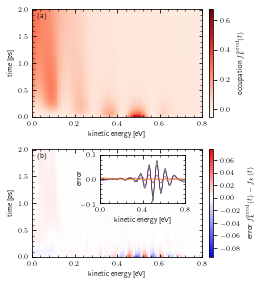

In [8]:
tmax = 2
n_tmax = 400
kmax = 4


E_el = ELPH_dyn.electron_dispersion(np.linspace(0,kmax,n_kmax,endpoint=True),0)
t = np.linspace(0,tmax,test_run.shape[1])

err = pred-test_run


####################################################
####################################################
####################################################

from matplotlib import rc
rc('text', usetex=True)

from matplotlib import gridspec
import matplotlib.ticker as ticker

fs = 7
fig = plt.figure(figsize=(3.5,4.0))
plt.rcParams.update({'font.size': fs})
gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[1,0.025], height_ratios=[1,1])


####################################################
####################################################
####################################################


ax00 = plt.subplot(gs[0,0])

im = plt.pcolormesh(E_el,t,pred.T, cmap='Reds', shading='auto', rasterized=True)
# cbar = plt.colorbar()
# cbar.set_label(r'error')

# plt.ylim(0,1.2)
plt.xlim(0,0.8)


plt.ylabel(r'time [ps]')
plt.xlabel(r'kinetic energy [eV]')

ax00.xaxis.set_ticks_position('both')
ax00.yaxis.set_ticks_position('both')
ax00.tick_params(which='both', direction='in', color='k')

ax00.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax00.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
# ax00.xaxis.set_major_formatter(ticker.NullFormatter())
# ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

ax00.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax00.xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
#ax00.yaxis.set_major_formatter(ticker.NullFormatter())
#ax00.yaxis.set_minor_formatter(ticker.NullFormatter())

plt.text(0.03, 0.97,r'(a)', horizontalalignment='left', verticalalignment='top', transform=ax00.transAxes)


axCB = plt.subplot(gs[0,1])

cb = plt.colorbar(im, cax = axCB)
cb.set_label(r"occupation $f_k^{\rm pred}(t)$")


####################################################
####################################################
####################################################


ax00 = plt.subplot(gs[1,0])

vmin = err.min()
vmax = err.max()
        
midnorm = MidpointNormalize(vmin=vmin, vcenter=0.0, vmax=vmax)

im = plt.pcolormesh(E_el,t,err.T,norm=midnorm, cmap='bwr', shading='auto', rasterized=True)
# cbar = plt.colorbar()
# cbar.set_label(r'error')

# plt.ylim(0,1.2)
plt.xlim(0,0.8)


plt.ylabel(r'time [ps]')
plt.xlabel(r'kinetic energy [eV]')

ax00.xaxis.set_ticks_position('both')
ax00.yaxis.set_ticks_position('both')
ax00.tick_params(which='both', direction='in', color='k')

ax00.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax00.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
# ax00.xaxis.set_major_formatter(ticker.NullFormatter())
# ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

ax00.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax00.xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
#ax00.yaxis.set_major_formatter(ticker.NullFormatter())
#ax00.yaxis.set_minor_formatter(ticker.NullFormatter())

plt.text(0.03, 0.97,r'(b)', horizontalalignment='left', verticalalignment='top', transform=ax00.transAxes)


axCB = plt.subplot(gs[1,1])

cb = plt.colorbar(im, cax = axCB)
cb.set_label(r"error $f_k^{\rm pred}(t) - f_k(t)$")


####################################################
####################################################
####################################################


axins = ax00.inset_axes([0.40, 0.5, 0.50, 0.45])

cmap = plt.get_cmap('inferno')
tn_arr = np.geomspace(1,n_tmax,5,dtype=int)-1

# axins.grid(0.5)
for k,tn in enumerate(tn_arr):
#     axins.plot(E_el,pred[:,tn], '-', c=cmap(k/len(tn_arr)), lw = 0.5)
#     axins.plot(E_el,test_run[:,tn], '--', c=cmap(k/len(tn_arr)), lw = 0.5)
    axins.plot(E_el,pred[:,tn]-test_run[:,tn], '-', c=cmap(k/len(tn_arr)), lw = 0.5)
    
    
axins.plot([-2,-1],[1,1],'-', label='prediction', c='k', lw=0.7)
axins.plot([-2,-1],[1,1],'--', label='truth', c='k', lw=0.7)
# plt.legend(fontsize=fs-1)
    
axins.set_xlabel('kinetic energy [eV]')
axins.set_ylabel('error',labelpad=-2)
axins.set_xlim(0,0.8)
axins.set_ylim(-0.1,0.1)


axins.xaxis.set_ticks_position('both')
axins.yaxis.set_ticks_position('both')
axins.tick_params(which='both', direction='in', color='k')

axins.xaxis.set_major_locator(ticker.MultipleLocator(0.4))
axins.xaxis.set_minor_locator(ticker.MultipleLocator(0.08))
# ax00.xaxis.set_major_formatter(ticker.NullFormatter())
# ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

axins.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
axins.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))
#ax00.yaxis.set_major_formatter(ticker.NullFormatter())
#ax00.yaxis.set_minor_formatter(ticker.NullFormatter())



# plt.text(0.03, 0.97,r'(c)', horizontalalignment='left', verticalalignment='top', transform=ax00.transAxes)

####################################################
####################################################
####################################################

plt.tight_layout()

plt.subplots_adjust(left=0.11, bottom=0.09, right=0.83, top=0.95, wspace=0.08, hspace=0.3)

plt.savefig('/home/agluedge/Preprints/ELPH/figs/autoregression_example.pdf', dpi=600)
plt.show()



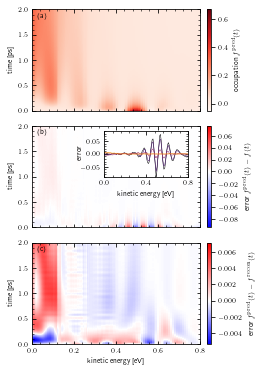

In [29]:
tmax = 2
n_tmax = 400
kmax = 4


E_el = ELPH_dyn.electron_dispersion(np.linspace(0,kmax,n_kmax,endpoint=True),0)
t = np.linspace(0,tmax,test_run.shape[1])

err = pred-test_run

err_SVD = pred - test_run_SVDapprx

####################################################
####################################################
####################################################

from matplotlib import rc
rc('text', usetex=True)

from matplotlib import gridspec
import matplotlib.ticker as ticker

fs = 7
fig = plt.figure(figsize=(3.5,5.0))
plt.rcParams.update({'font.size': fs})
gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=[1,0.025], height_ratios=[1,1,1])


####################################################
####################################################
####################################################


ax00 = plt.subplot(gs[0,0])

im = plt.pcolormesh(E_el,t,pred.T, cmap='Reds', shading='auto', rasterized=True)
# cbar = plt.colorbar()
# cbar.set_label(r'error')

# plt.ylim(0,1.2)
plt.xlim(0,0.8)


plt.ylabel(r'time [ps]')
# plt.xlabel(r'kinetic energy [eV]')

ax00.xaxis.set_ticks_position('both')
ax00.yaxis.set_ticks_position('both')
ax00.tick_params(which='both', direction='in', color='k')

ax00.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax00.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax00.xaxis.set_major_formatter(ticker.NullFormatter())
ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

ax00.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax00.xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
#ax00.yaxis.set_major_formatter(ticker.NullFormatter())
#ax00.yaxis.set_minor_formatter(ticker.NullFormatter())

plt.text(0.03, 0.97,r'(a)', horizontalalignment='left', verticalalignment='top', transform=ax00.transAxes)


axCB = plt.subplot(gs[0,1])

cb = plt.colorbar(im, cax = axCB)
cb.set_label(r"occupation $f^{\rm pred}(t)$")


####################################################
####################################################
####################################################


ax00 = plt.subplot(gs[1,0])

vmin = err.min()
vmax = err.max()
        
midnorm = MidpointNormalize(vmin=vmin, vcenter=0.0, vmax=vmax)

im = plt.pcolormesh(E_el,t,err.T,norm=midnorm, cmap='bwr', shading='auto', rasterized=True)
# cbar = plt.colorbar()
# cbar.set_label(r'error')

# plt.ylim(0,1.2)
plt.xlim(0,0.8)


plt.ylabel(r'time [ps]')
# plt.xlabel(r'kinetic energy [eV]')

ax00.xaxis.set_ticks_position('both')
ax00.yaxis.set_ticks_position('both')
ax00.tick_params(which='both', direction='in', color='k')

ax00.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax00.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax00.xaxis.set_major_formatter(ticker.NullFormatter())
ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

ax00.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax00.xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
#ax00.yaxis.set_major_formatter(ticker.NullFormatter())
#ax00.yaxis.set_minor_formatter(ticker.NullFormatter())

plt.text(0.03, 0.97,r'(b)', horizontalalignment='left', verticalalignment='top', transform=ax00.transAxes)


axCB = plt.subplot(gs[1,1])

cb = plt.colorbar(im, cax = axCB)
cb.set_label(r"error $f^{\rm pred}(t) - f(t)$")


####################################################
####################################################
####################################################


axins = ax00.inset_axes([0.43, 0.5, 0.50, 0.45])

cmap = plt.get_cmap('inferno')
tn_arr = np.geomspace(1,n_tmax,5,dtype=int)-1

# axins.grid(0.5)
for k,tn in enumerate(tn_arr):
#     axins.plot(E_el,pred[:,tn], '-', c=cmap(k/len(tn_arr)), lw = 0.5)
#     axins.plot(E_el,test_run[:,tn], '--', c=cmap(k/len(tn_arr)), lw = 0.5)
    axins.plot(E_el,pred[:,tn]-test_run[:,tn], '-', c=cmap(k/len(tn_arr)), lw = 0.5)
    
    
axins.plot([-2,-1],[1,1],'-', label='prediction', c='k', lw=0.7)
axins.plot([-2,-1],[1,1],'--', label='truth', c='k', lw=0.7)
# plt.legend(fontsize=fs-1)
    
axins.set_xlabel('kinetic energy [eV]')
axins.set_ylabel('error',labelpad=-2)
axins.set_xlim(0,0.8)
axins.set_ylim(-0.09,0.09)


axins.xaxis.set_ticks_position('both')
axins.yaxis.set_ticks_position('both')
axins.tick_params(which='both', direction='in', color='k')

axins.xaxis.set_major_locator(ticker.MultipleLocator(0.4))
axins.xaxis.set_minor_locator(ticker.MultipleLocator(0.08))
# ax00.xaxis.set_major_formatter(ticker.NullFormatter())
# ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

axins.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
axins.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
#ax00.yaxis.set_major_formatter(ticker.NullFormatter())
#ax00.yaxis.set_minor_formatter(ticker.NullFormatter())



####################################################
####################################################
####################################################

####################################################
####################################################
####################################################


ax00 = plt.subplot(gs[2,0])

vmin = err_SVD.min()
vmax = err_SVD.max()
        
midnorm = MidpointNormalize(vmin=vmin, vcenter=0.0, vmax=vmax)

im = plt.pcolormesh(E_el,t,err_SVD.T,norm=midnorm, cmap='bwr', shading='auto', rasterized=True)
# cbar = plt.colorbar()
# cbar.set_label(r'error')

# plt.ylim(0,1.2)
plt.xlim(0,0.8)


plt.ylabel(r'time [ps]')
plt.xlabel(r'kinetic energy [eV]')

ax00.xaxis.set_ticks_position('both')
ax00.yaxis.set_ticks_position('both')
ax00.tick_params(which='both', direction='in', color='k')

ax00.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax00.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
# ax00.xaxis.set_major_formatter(ticker.NullFormatter())
# ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

ax00.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax00.xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
#ax00.yaxis.set_major_formatter(ticker.NullFormatter())
#ax00.yaxis.set_minor_formatter(ticker.NullFormatter())

plt.text(0.03, 0.97,r'(c)', horizontalalignment='left', verticalalignment='top', transform=ax00.transAxes)


axCB = plt.subplot(gs[2,1])

cb = plt.colorbar(im, cax = axCB)
cb.set_label(r"error $f^{\rm pred}(t) - f^{\rm recon}(t)$")


####################################################
####################################################
####################################################


# axins = ax00.inset_axes([0.43, 0.5, 0.50, 0.45])

# cmap = plt.get_cmap('inferno')
# tn_arr = np.geomspace(1,n_tmax,5,dtype=int)-1

# # axins.grid(0.5)
# for k,tn in enumerate(tn_arr):
#     axins.plot(E_el,err_SVD[:,tn], '-', c=cmap(k/len(tn_arr)), lw = 0.5)
    
    
# axins.plot([-2,-1],[1,1],'-', label='prediction', c='k', lw=0.7)
# axins.plot([-2,-1],[1,1],'--', label='truth', c='k', lw=0.7)
# # plt.legend(fontsize=fs-1)
    
# axins.set_xlabel('kinetic energy [eV]')
# axins.set_ylabel('error',labelpad=-2)
# axins.set_xlim(0,0.8)
# axins.set_ylim(-0.005,0.007)


# axins.xaxis.set_ticks_position('both')
# axins.yaxis.set_ticks_position('both')
# axins.tick_params(which='both', direction='in', color='k')

# axins.xaxis.set_major_locator(ticker.MultipleLocator(0.4))
# axins.xaxis.set_minor_locator(ticker.MultipleLocator(0.08))
# # ax00.xaxis.set_major_formatter(ticker.NullFormatter())
# # ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

# axins.yaxis.set_major_locator(ticker.MultipleLocator(0.005))
# axins.yaxis.set_minor_locator(ticker.MultipleLocator(0.001))
# #ax00.yaxis.set_major_formatter(ticker.NullFormatter())
# #ax00.yaxis.set_minor_formatter(ticker.NullFormatter())



####################################################
####################################################
####################################################



plt.tight_layout()

plt.subplots_adjust(left=0.11, bottom=0.06, right=0.82, top=0.99, wspace=0.08, hspace=0.15)

plt.savefig('/home/agluedge/Preprints/ELPH/figs/autoregression_example.pdf', dpi=600)
plt.show()

